# LAB 6 - CART

This lab is comprised of two main sections:

- 1. Classification Trees

- 2. Regression Trees

The lab we will dive deeper into the `sklearn` package to make use of algorithms such as Classification Trees (`DecisionTreeClassifier`) and Regression Trees (`DecisionTreeRegressor`).

### Load the Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
parole = pd.read_csv("NYCparole.csv")
parole.info()
parole.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6102 entries, 0 to 6101
Data columns (total 7 columns):
Violator      6102 non-null int64
Male          6102 non-null int64
Age           6102 non-null float64
TimeServed    6102 non-null float64
Class         6102 non-null object
Multiple      6102 non-null int64
InCity        6102 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 333.8+ KB


,Violator,Male,Age,TimeServed,Class,Multiple,InCity
0,0,1,49.4,3.15,D,0,1
1,1,1,26.0,5.95,D,1,0
2,0,1,24.9,2.25,D,1,0
3,0,1,52.1,29.22,A,0,0
4,0,1,35.9,12.78,A,1,1


## 1. CLASSIFICATION TREES

Is CART an appropriate model for classification with Parole data? 

https://datascience.stackexchange.com/questions/6048/decision-tree-or-logistic-regression

### Casting the response variable as Integer

In [3]:
parole['Violator'] = parole['Violator'].astype('int64')

### Dummy Encoding

In previous labs with `statsmodels`, we left the handling of categorical variables to the model.
With `sklearn` packages, we need to do the categorical encoding ourselves.


Two widely used types of categorical encoding are "Dummy Encoding" and "One-hot encoding":
- Dummy encoding converts a variable that has n possible distinct values, into n-1 binary variables. 
- One-hot encoding converts a variable with n possible distinct values, into n binary variables.  

For regression-type problems Dummy Encoding is preferable as we wish to avoid perfect collinearity between the binary variables that are being generated by the encoding. In the classification problem however, we are not concerned about inflating factors and hence can choose either of the two schemes. They will produce equivalent encodings.

We will apply the encoding scheme to the `Class` variable.

In [5]:
parole_enc = pd.get_dummies(parole, columns = ['Class'])

In [6]:
parole_enc_2 =  pd.get_dummies(parole, columns = ['Class'], drop_first=True)

`pd.get_dummies()` can also automatically detect the categorical columns if no specific columns are given.

By default `pd.get_dummies()` does one-hot enocoding. To do dummy encoding, you need to pass the parameter `drop_first=True`.

In [7]:
parole_enc.info()
parole_enc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6102 entries, 0 to 6101
Data columns (total 11 columns):
Violator      6102 non-null int64
Male          6102 non-null int64
Age           6102 non-null float64
TimeServed    6102 non-null float64
Multiple      6102 non-null int64
InCity        6102 non-null int64
Class_A       6102 non-null uint8
Class_B       6102 non-null uint8
Class_C       6102 non-null uint8
Class_D       6102 non-null uint8
Class_E       6102 non-null uint8
dtypes: float64(2), int64(4), uint8(5)
memory usage: 316.0 KB


,Violator,Male,Age,TimeServed,Multiple,InCity,Class_A,Class_B,Class_C,Class_D,Class_E
0,0,1,49.4,3.15,0,1,0,0,0,1,0
1,1,1,26.0,5.95,1,0,0,0,0,1,0
2,0,1,24.9,2.25,1,0,0,0,0,1,0
3,0,1,52.1,29.22,0,0,1,0,0,0,0
4,0,1,35.9,12.78,1,1,1,0,0,0,0


In [8]:
parole_enc_2.info()
parole_enc_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6102 entries, 0 to 6101
Data columns (total 10 columns):
Violator      6102 non-null int64
Male          6102 non-null int64
Age           6102 non-null float64
TimeServed    6102 non-null float64
Multiple      6102 non-null int64
InCity        6102 non-null int64
Class_B       6102 non-null uint8
Class_C       6102 non-null uint8
Class_D       6102 non-null uint8
Class_E       6102 non-null uint8
dtypes: float64(2), int64(4), uint8(4)
memory usage: 310.0 KB


,Violator,Male,Age,TimeServed,Multiple,InCity,Class_B,Class_C,Class_D,Class_E
0,0,1,49.4,3.15,0,1,0,0,1,0
1,1,1,26.0,5.95,1,0,0,0,1,0
2,0,1,24.9,2.25,1,0,0,0,1,0
3,0,1,52.1,29.22,0,0,0,0,0,0
4,0,1,35.9,12.78,1,1,0,0,0,0


**How many of each Violator = 0 and Violator = 1 do we have?**

In [9]:
violator_0 = len(parole_enc[parole['Violator']==0])
violator_1 = len(parole_enc[parole['Violator']==1])

print(pd.Series({'non_violators': violator_0, 'violators': violator_1}))

non_violators    5767
violators         335
dtype: int64


### Splitting the Data

In [10]:
from sklearn.model_selection import train_test_split

y = parole_enc['Violator']
X = parole_enc.drop(['Violator'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,  
                                                    stratify=parole_enc['Violator'],
                                                    random_state=88,)
X_train.shape, X_test.shape

((4271, 10), (1831, 10))

We use the parameter `stratify=parole_enc['Violator']` because there is a large imbalance in the distribution of the target class. In such cases it is recommended to use stratified sampling to ensure that relative class frequencies is approximately preserved in each train and validation fold.

In [11]:
# BASELINE

negative = np.sum(y_train == 0)
positive = np.sum(y_train == 1)
print(pd.Series({'0': negative, '1': positive}))

0    4037
1     234
dtype: int64


### Decision Tree Classifier

`skelarn`'s `DecisionTreeClassifier` is just one of many implementations that we can use for our classification problem

In [12]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(min_samples_leaf=5, 
                             ccp_alpha=0.001,
                             random_state = 88)

dtc = dtc.fit(X_train, y_train)

In this example, we are arbitrarily setting `min_samples_leaf=5`, which denotes the lower limit of the number of observations in each bucket/region. If a bucket contains less than `min_samples_leaf` then it will not split further. `ccp_alpha=0.001` is our complexity parameter (cp) to perform pruning. The smaller the cp value, the more splits there will be in the tree (larger, deeper tree). The larger the cp value, the less splits there will be in the tree (smaller, shallower tree). For classification, a split must decrease the impurity by at least the indicated amount of the cp in order for the split to remain.

Node count = 17


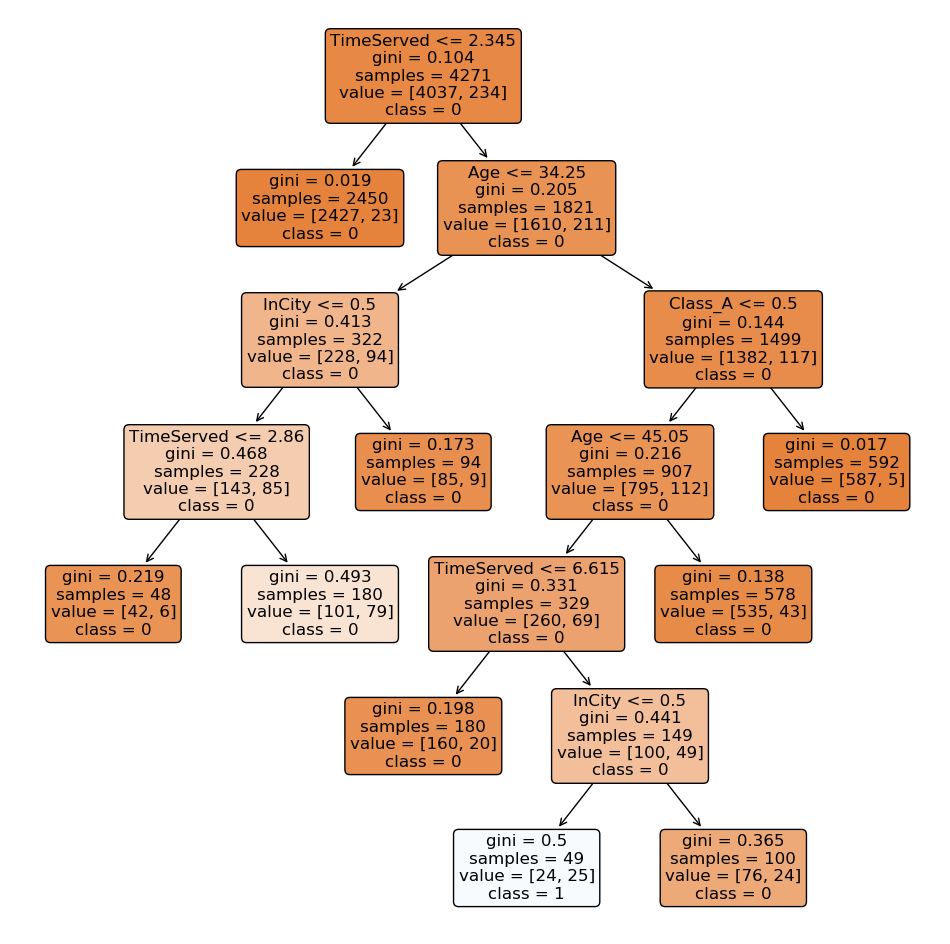

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

print('Node count =', dtc.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(dtc, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12) 
plt.show()

In [14]:
# MAKE PREDICTIONS 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_pred = dtc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm)
# print('Precision:',precision_score(y_test, y_pred))
# print('Recall:',recall_score(y_test, y_pred))

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print('Accuracy is: %.4f' %acc)
print('TPR is: %.4f' % TPR)
print('FPR is: %.4f' % FPR)

Confusion Matrix : 
 [[1721    9]
 [  88   13]]
Accuracy is: 0.9470
TPR is: 0.1287
FPR is: 0.0052


To remind you of what each element of the confusion matrix represents:

TN FP

FN TP

### Pruning

Node count = 5


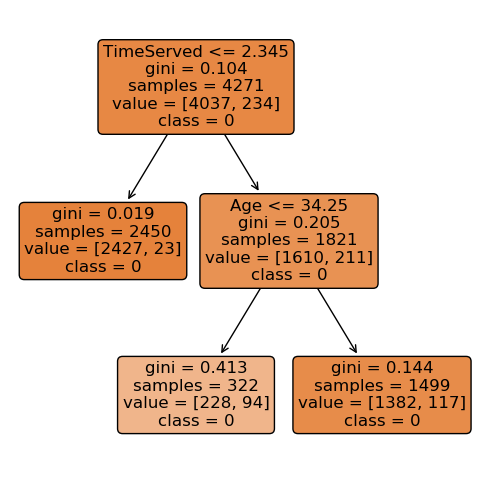

In [15]:
# Try increasing the complexity parameter to prune the tree --> the larger ccp_alpha, shallower the tree

dtc2 = DecisionTreeClassifier(min_samples_leaf=5, 
                              ccp_alpha=0.005,
                              random_state = 88)

dtc2 = dtc2.fit(X_train, y_train)

print('Node count =', dtc2.tree_.node_count)
plt.figure(figsize=(6,6))
plot_tree(dtc2, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12)  
plt.show() 

**Note:** This tree is so shallow that it doesn't actually know when to classify something as a 1 (as a "Violator). In general, this is why we are okay with making the tree deep at first, then tuning `ccp_alpha` later via CV to prune the tree later.

In [16]:
# MAKE PREDICTIONS 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_pred = dtc2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm)
# print('Precision:',precision_score(y_test, y_pred))
# print('Recall:',recall_score(y_test, y_pred))

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print('Accuracy is: %.4f' %acc)
print('TPR is: %.4f' % TPR)
print('FPR is: %.4f' % FPR)

Confusion Matrix : 
 [[1730    0]
 [ 101    0]]
Accuracy is: 0.9448
TPR is: 0.0000
FPR is: 0.0000


We can observe that our tree is not able to discern very well between positive cases of `Violator` and negative cases of `Violator`. The highly imbalanced dataset is likely to be one of the reasons why our predictions are heavily tilted towards `Violator = 0`. We will address the class imbalance with the help of a custom loss function. More specifically, we will assign individual weights to each of the classes. 

### Custom Losses and Weights

Ideally we would like to produce a loss function that can reflect specific penalties for the various types of classification choices.

- cost_TP = 0
- cost_TN = 0
- cost_FP = 1
- cost_FN = 20

With the `sklearn`'s implementation of `DecisionTreeClassifier`, we are not able to incorporate directly such a function. However, we can achieve the same result by assigning weights to the classes in a way that it mimics the presence of more observations of the minority class. This will accomplish the goal of rebalancing our model. Alternatively, you can set `class_weight=balanced`, which uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`

Node count = 15


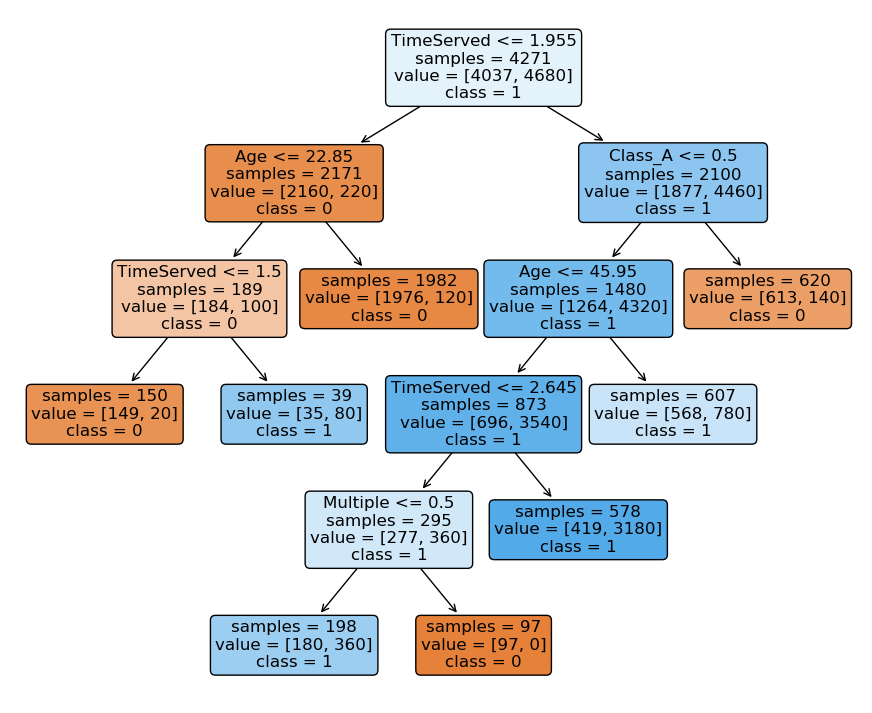

Confusion Matrix : 
 [[1219  511]
 [   7   94]]
Accuracy is: 0.7171
TPR is: 0.9307
FPR is: 0.2954


In [17]:
dtc3 = DecisionTreeClassifier(min_samples_leaf=5, 
                              ccp_alpha=0.005,
                              class_weight = {0: 1, 1: 20},
                              random_state = 88)

dtc3 = dtc3.fit(X_train, y_train)

print('Node count =', dtc3.tree_.node_count)
plt.figure(figsize=(11,9))
plot_tree(dtc3, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12) 
plt.show()

y_pred = dtc3.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm) 
# print('Precision:',precision_score(y_test, y_pred))
# print('Recall:',recall_score(y_test, y_pred))

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print('Accuracy is: %.4f' %acc)
print('TPR is: %.4f' % TPR)
print('FPR is: %.4f' % FPR)

Node count = 11


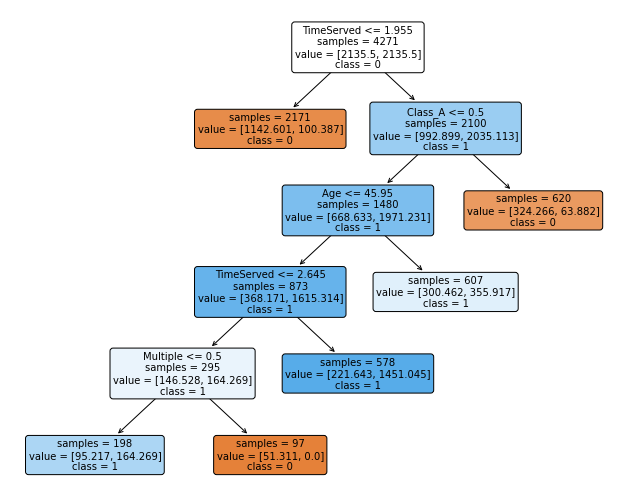

Confusion Matrix : 
 [[1239  491]
 [   7   94]]
Accuracy is: 0.7280
TPR is: 0.9307
FPR is: 0.2838


In [17]:
dtc4 = DecisionTreeClassifier(min_samples_leaf=5, 
                              ccp_alpha=0.005,
                              class_weight = 'balanced',
                              random_state = 88)

dtc4 = dtc4.fit(X_train, y_train)

print('Node count =', dtc4.tree_.node_count)
plt.figure(figsize=(11,9))
plot_tree(dtc4, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=10) 
plt.show()

y_pred = dtc4.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm) 
# print('Precision:',precision_score(y_test, y_pred))
# print('Recall:',recall_score(y_test, y_pred))

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print('Accuracy is: %.4f' %acc)
print('TPR is: %.4f' % TPR)
print('FPR is: %.4f' % FPR)

## 2. REGRESSION TREES

For the Regression Tree example, we use our old wine dataset:

In [18]:
wine = pd.read_csv("wine_agg.csv")
wine.head()
len(wine)

46

In [20]:
wine_train = wine[wine['Year'] <= 1985]
wine_test = wine[wine['Year'] > 1985]

y_train = wine_train['LogAuctionIndex']
X_train = wine_train.drop(['LogAuctionIndex'], axis=1)
X_train.shape

(31, 8)

### Decision Tree Regressor

In [21]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(min_samples_split=10, 
                            ccp_alpha=0.02,
                            random_state = 88)
dtr = dtr.fit(X_train, y_train)

Node count = 9


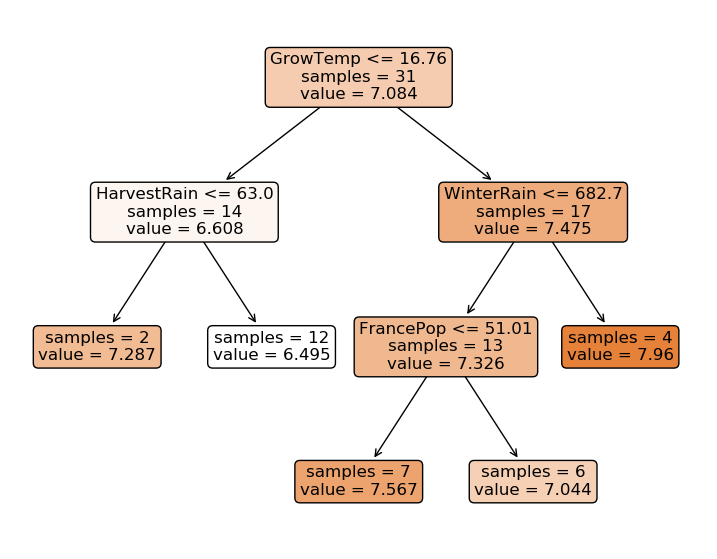

In [22]:
print('Node count =', dtr.tree_.node_count)
plt.figure(figsize=(9,7))
plot_tree(dtr, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12)
plt.show()

In [23]:
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [24]:
y_test = wine_test['LogAuctionIndex']
X_test = wine_test.drop(['LogAuctionIndex'], axis=1)

print('OSR2:', OSR2(dtr, X_test, y_test, y_train))

OSR2: -0.171331426511258


A negative OSR2 is an indicator that the model doesn't work well on the test set. 